# Submitting a pulser Sequence to a QPU using pulser-myqlm

This notebook illustrates how to use Pulser to:
- build a sequence to prepare an antiferromagnetic state in an Ising-like model.
- submit this Sequence to a QPU using pulser-myqlm

We begin by importing some basic modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, QPUBackend, InterpolatedWaveform
from pulser.backend.remote import JobParams

from qat.qlmaas import QLMaaSConnection

from pulser_myqlm import PulserQLMConnection, IsingAQPU

Let's follow our step-by-step guide to pulse Sequence creation:

## Pick a Device

To prepare an AFM state, you need a Device containing at least a `Rydberg.Global` channel.
Since we want to run this Sequence on a QPU, let's connect to the QLM and see the Devices that are available.

The PulserQLMConnection can be used to access the QLM, and fetch the available devices, and their associated QPUs.

The PulserQLMConnection is a wrapper of a qat.qlmaas.QLMaaSConnection. It can be instantiated with the same arguments as the QLMaaSConnection:

In [2]:
conn = PulserQLMConnection()

PulserQLMConnection.fetch_available_devices returns a dictionnary, associating to each QPU inside the QLM that implements a pulser Device, the Device that it implements.

In [3]:
conn.fetch_available_devices()

{'qat.qpus:PasqalQPU': Fresnel}

Pick the device you want to address. Its specifications at the time of the fetch can be obtained using `print_specs`.

In [4]:
device = conn.fetch_available_devices()["qat.qpus:PasqalQPU"]
device.print_specs()

----------------------
Fresnel Specifications
----------------------

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 25
 - Maximum distance from origin: 35 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 10000 ns
 - Maximum number of runs: 2000

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=54.97787143782138, max_amp=12.56637061435917, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED:

## Define a Register

If the device requires a layout, you have to define the Register from a RegisterLayout.
If the device does not accept new layouts, then you have to define the Register from one of the calibrated_register_layouts of the device
Let's look at the layouts of the device:

Available layouts for the chosen device are: {'TriangularLatticeLayout(61, 5.0µm)': RegisterLayout_f771cf8ed8632985d8a9932015027bd73e90391c049e8a8591e2c663febcaafe}


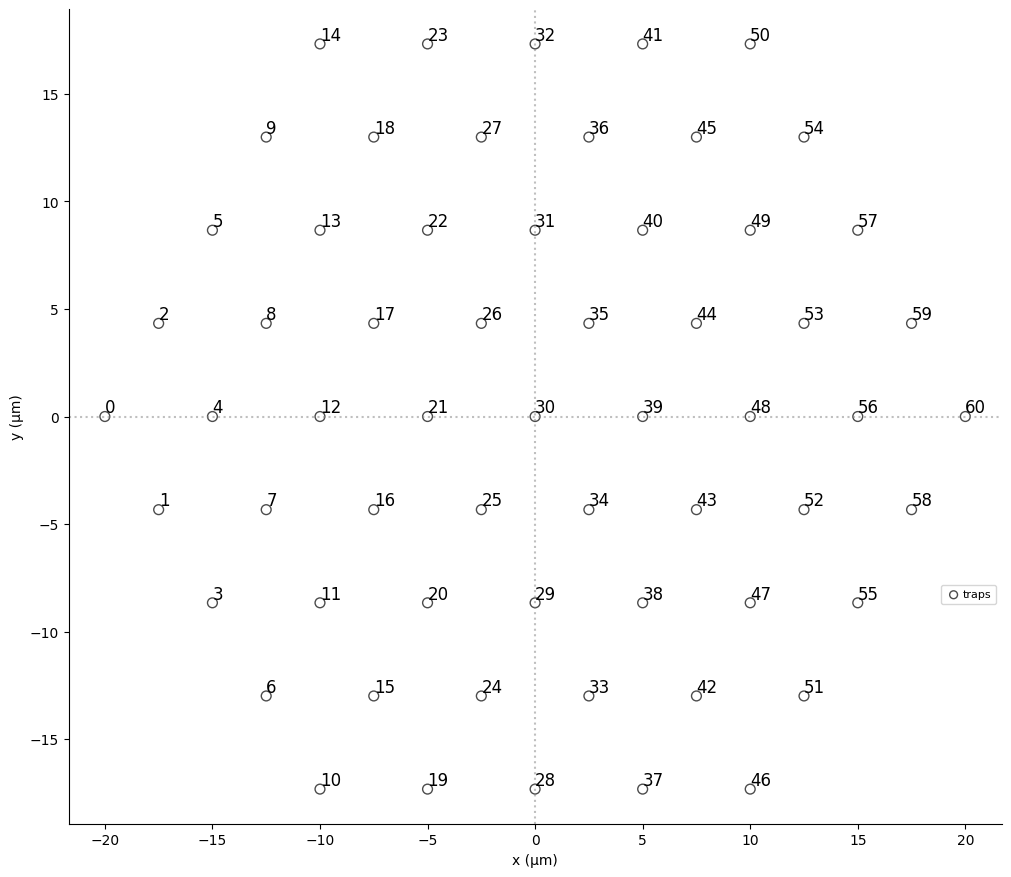

In [5]:
print(
    "Available layouts for the chosen device are:", device.calibrated_register_layouts
)
reg_layout = device.calibrated_register_layouts["TriangularLatticeLayout(61, 5.0µm)"]
reg_layout.draw()

Let's define a ring of atoms, spaced by 5.0 µm

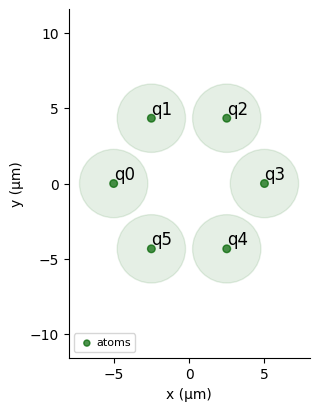

In [6]:
# Parameters in rad/µs and ns
reg_layout = device.calibrated_register_layouts["TriangularLatticeLayout(61, 5.0µm)"]

reg = reg_layout.define_register(21, 26, 35, 39, 34, 25)

Omega_max = 0.9 * 2 * device.rabi_from_blockade(5.0)  # Spacing between atoms
reg.draw(
    blockade_radius=device.rydberg_blockade_radius(Omega_max), draw_half_radius=True
)

We can now initialize a Sequence, that checks that the register matches the Device's constraints:

In [7]:
seq = Sequence(reg, device)

## Declaring the Channel

We need a `Rydberg.Global` channel for our computation:

In [8]:
seq.declare_channel("ising", "rydberg_global")

At this stage, our Sequence implements the Ising Hamiltonian.

## Add the pulses

We are going to use waveforms for omega and delta that have shown to be optimized to generate an AFM state. They are defined from `InterpolatedWaveforms`:

In [9]:
U = Omega_max / 2.0

T = 2  # us
params = [T] + (
    U * np.array([0.16768532, 0.2, 0.2, -1.0, -0.54656236, 0.05762063, 0.3673201, 1.0])
).tolist()

interpolated_pulse = Pulse(
    InterpolatedWaveform(
        T * 1000,
        U * np.array([1e-9, 0.16768532, 0.2, 0.2, 1e-9]),
        times=np.linspace(0, 1, 5),
    ),
    InterpolatedWaveform(
        T * 1000,
        U * np.array([-1.0, -0.54656236, 0.05762063, 0.3673201, 1.0]),
        times=np.linspace(0, 1, 5),
    ),
    0,
)

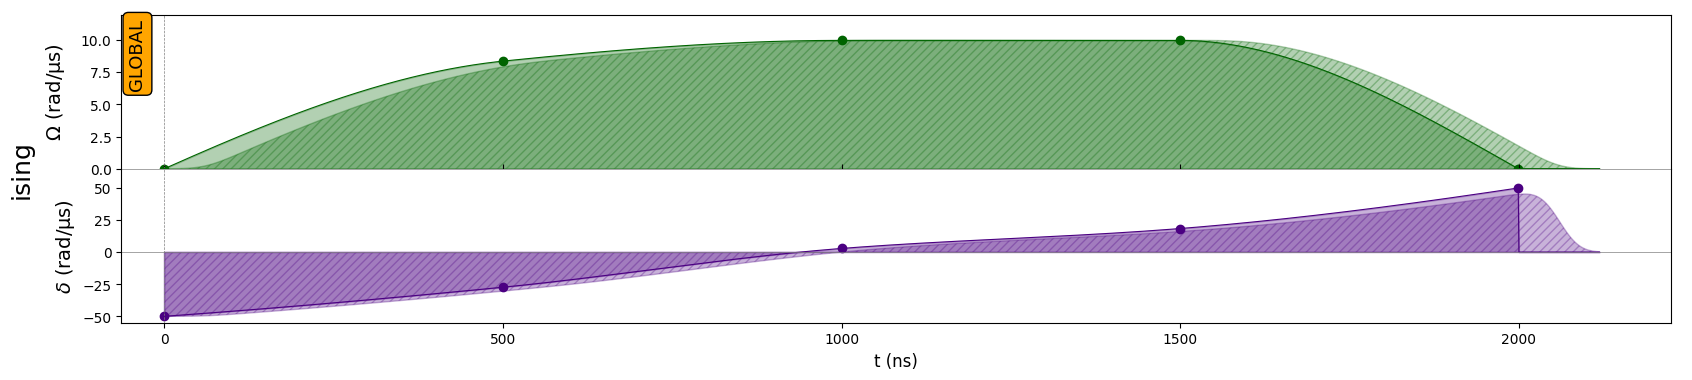

In [10]:
seq.add(interpolated_pulse, "ising")

seq.draw()

## Submitting to the QPU

Once built, pulser Sequences can be executed on pulser Backends. To execute the Sequence to a QPU connected to the QLM, let's use a  QPUBackend, taking the PulserQLMConnection as a connection:

In [11]:
qpu = QPUBackend(seq, connection=conn)

You can then use the method `run` of the backend to launch a Batch of Jobs execution, defined by their number of runs, and eventually by assigning a value to each variable if the Sequence is parametrized. This will return a pulser RemoteResults, that you can use to get your jobs once they are executed (if wait is set to True, the method run will wait for the job to be executed to return the RemoteResult):

In [12]:
result = qpu.run([JobParams(runs=1000, variables=[])], wait=True)

Submitted a new batch: SJob2082


In [13]:
result.batch_id

'SJob2082'

In [14]:
result.get_available_results()

{'SJob2082': SampledResult(atom_order=('q0', 'q1', 'q2', 'q3', 'q4', 'q5'), total_duration=0, _results={UUID('00000000-0000-0000-0000-000000000000'): [Counter({'101010': 504, '010101': 493, '100100': 2, '000101': 1})]}, _times={UUID('00000000-0000-0000-0000-000000000000'): [1.0]}, _tagmap={'bitstrings': UUID('00000000-0000-0000-0000-000000000000')}, meas_basis='ground-rydberg', bitstring_counts=Counter({'101010': 504, '010101': 493, '100100': 2, '000101': 1}), evaluation_time=1.0)}

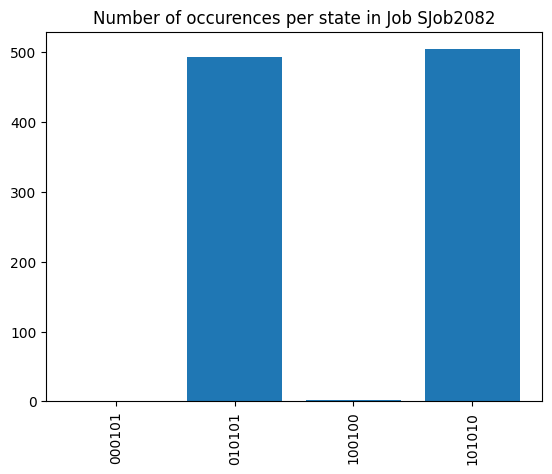

In [15]:
for job_id, sampled_res in result.get_available_results().items():
    counter = sampled_res.bitstring_counts
    plt.bar(list(counter.keys()), list(counter.values()))
    plt.xticks(rotation="vertical")
    plt.title(f"Number of occurences per state in Job {job_id}")
    plt.show()

This is an Antiferromagnetic state !

## Submitting to the QPU, using MyQLM objects

If you are more used to manipulating MyQLM objects, or if you want to submit to a specific myQLM QPU, you can start by connecting to the QLM using the same QLMaaSConnection

In [16]:
qlm_conn = QLMaaSConnection()

You can retrieve the jobs that were submitted via PulserQLMConnection:

In [17]:
qlm_conn.get_job(result.batch_id).get_result()

Result(raw_data=[Sample(_state=b'\x05', probability=0.001, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=6, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=b'\x15', probability=0.493, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=6, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=b'$', probability=0.002, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=6, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=b'*', probability=0.504, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=6, start=0, msb=None, _subtype_metadata=None, key=None)])], _value=None, error=None, value_data=None, error_data=None, meta_data={'n_samples': '1000', 'n_qubits': '6', 'single_job': 'True'}, in_memory=None, data=None, qregs=[DefaultRegister(length=6, start=0, msb=None, _subtype_metadata=

Number of occurences per state in Job SJob2082:


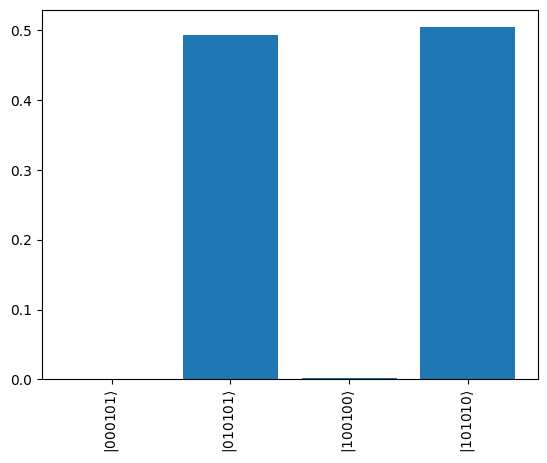

In [18]:
for job_id in result.job_ids:
    print(f"Number of occurences per state in Job {job_id}:")
    qlm_conn.get_job(job_id).get_result().plot()

You can also submit your Sequence to any QPU enabling the simulation of time-dependent Hamiltonian. Let's begin by converting your Sequence into a myQLM Job:

In [19]:
myqlm_job = IsingAQPU.convert_sequence_to_job(seq, nbshots=100)

And then submitting it to either a QPU supporting the execution of pulser Sequence (the ones that appear in PulserQLMConnection.fetch_available_devices):

All the available QPUs: ['qat.qpus:QutipQPU', 'qat.qpus:AnalogQPU', 'qat.qpus:SQAQPU', 'qat.qpus:Bdd', 'qat.qpus:RemoteQPU', 'qat.qpus:Feynman', 'qat.qpus:ClassicalQPU', 'qat.qpus:LinAlg', 'qat.qpus:MPSLegacy', 'qat.qpus:MPS', 'qat.qpus:MPO', 'qat.qpus:MPSTraj', 'qat.qpus:NoisyQProc', 'qat.qpus:UploadedQPU', 'qat.qpus:QPEG', 'qat.qpus:Stabs', 'qat.qpus:PasqalQPU']
Submitted a new batch: SJob2083


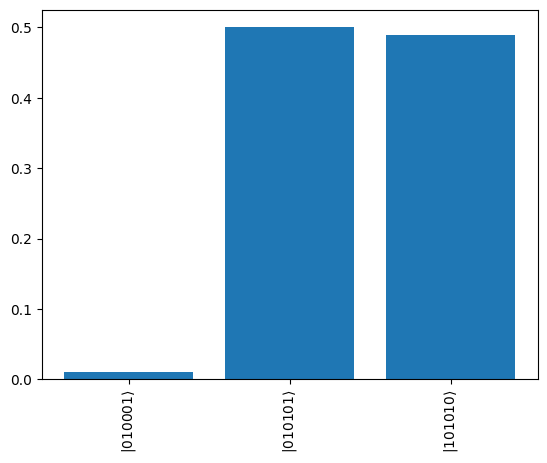

In [20]:
print("All the available QPUs:", qlm_conn.get_qpus())
qpu_res = qlm_conn.get_qpu("qat.qpus:PasqalQPU")().submit(myqlm_job)
qpu_res.join().plot()

Or any simulator that can simulate Job with a Schedule, like `AnalogQPU`:

Submitted a new batch: SJob2084


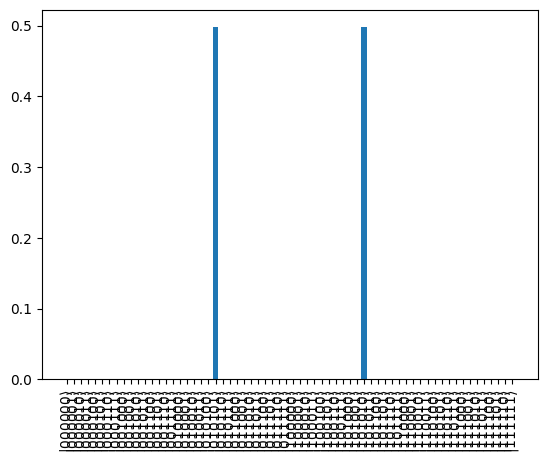

In [21]:
myqlm_job = IsingAQPU.convert_sequence_to_job(
    seq, nbshots=0
)  # Has to be 0 for AnalogQPU
analog_res = qlm_conn.get_qpu("qat.qpus:AnalogQPU")().submit(myqlm_job)
analog_res.join().plot()